* if "save_figs" == True -> the plots will be saved as png to "./output//" folder
* Importing modules from the LPA packge
* Importing modules for program useage

In [1]:
save_figs = False

# loading LPA 
from resources.LPA import Corpus, sockpuppet_distance
from resources.functions import do_pca, mask_df, domain_heatmap, pca_scatter, get_scatter

# Loading required modules for analysis
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from natsort import natsorted

-----
* Creating output folder if it dosent exists

In [41]:
if os.path.exists("output") is False:
    os.mkdir("output")
    print("output folder was created.")

output folder was created.


---

* Loading the frequency dataframe from the input folder.
* Renaming the document name to the convension of: antigen_target.time_point.subject_id
* Choosing only positions > 27 f
* Dropping rows with less then 10 mutations (and saving the report)


In [2]:
#loading input datasets 
input_name = "input_example"
[i.split(".")[1] for i in os.listdir(input_name)]
for i in os.listdir(input_name):
    path = f"{input_name}\\"+(i)
    globals()[i.split(".")[1]] = pd.read_csv(path, index_col=0)

#dropping rows with "frequency_in_document" < 10, out treshold is 10.
documents["document"] = [".".join([i[0],i[1],i[2]]) for i in [j.split(".") for j in documents.document]]

# From aa position 28 onward (include)
documents = documents[documents["element"] > 27]

# drop words with small frequency (<10)
documents.loc[documents["frequency_in_document"] < 10, "frequency_in_document"] = 0
docuemnts_zero = documents[documents["frequency_in_document"] < 10].reset_index(drop=True)
documents = documents[documents["frequency_in_document"] >= 10]

# drop words with insefishent number of documents (< 70%)
above_80p = documents.groupby("element")["document"].nunique() > round(documents.document.nunique()*0.6)
documents = documents[documents.element.isin(above_80p[above_80p == True].index)]

In [3]:
# Filtring out reporiores with less than 80% of the positions values
docs_len = documents.groupby("document").size()/len(documents.element.unique())
treshold_p = 0.9
small_docs = docs_len[docs_len < treshold_p]
big_docs = docs_len[docs_len >= treshold_p]

# Filtring the reportiore dataframe accordinly
documents = documents[documents.document.isin(big_docs.index)]

In [4]:
zero_list = []
for i in documents.document.unique():
    zero_list.append([i,(documents[documents["document"]==i].frequency_in_document == 0).sum()])

In [5]:
cond_dataset = documents.document.str.split("_").map(lambda X : X[0]) == "a"
dataset_a = documents[cond_dataset]
dataset_b = documents[np.invert(cond_dataset)]

---
* Using the LPA packge functions to create a domain (from all the documents)
> > document = dataset </br>
> > word = amino acid position
* Defining the episolin for the signature calculations
* Calculaing the singature for each word in each document
* Creating dataframe with all the signatures

In [6]:
# creating corpus and domain 
corpus = Corpus(documents)
dvr = corpus.create_dvr()

# sorting the domain by element value
dvr_sort = dvr.sort_values(by="element").reset_index(drop=True)

# defining epsilon for KLDe distance calculation
epsilon_frac = 2
epsilon = 1 / (len(dvr) * epsilon_frac)

# creating distances signatures for each document
signatures = corpus.create_signatures(epsilon=epsilon, sig_length=500, distance="KLDe")
sig_list = [i.sort_index() for i in signatures]

sig_df = dvr_sort.copy()["element"].to_frame()

# Creating dataframe of signatures
for i in sig_list:
    sig_df = sig_df.merge(right=i.to_frame(), how="left", left_on="element", right_index=True) 
    
sig_df.set_index(keys="element", drop=True, inplace=True)
sig_df = sig_df[np.sort(sig_df.columns)]

----
* Dropping all the nan / inf values in the signatures dataframe for further processing

In [7]:
drop=False
if drop:
   sig_df.replace([np.inf, -np.inf], np.nan, inplace=True)
   for i in [0,1]:
       sig_df.dropna(axis=i, how="all", inplace=True)

matrix_input = sig_df.copy()

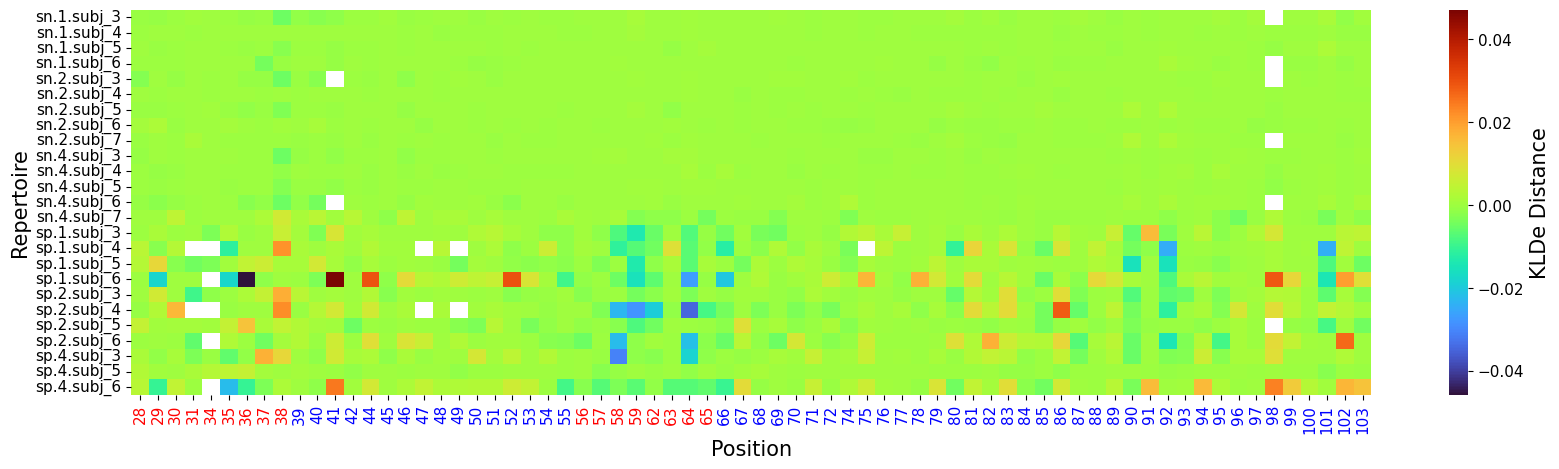

In [8]:
mask_zeros = mask_df(matrix_input, docuemnts_zero)[matrix_input.columns]

domain_heatmap(domain_df = matrix_input, 
               mask_input = mask_zeros)

---
* Anlyzing the world distrebution in the domain to see if Ziff's law takes place (it's not)

# Zipf Distribution
Zipf’s Law Formula

Zipf’s law states that the frequency f(r) of a word is inversely proportional to its rank r:<br>
> f(r)=C⋅r**−α

where:
>   * C is a normalization constant (the frequency of the most common word). <br>
>   * α is the Zipf exponent (typically close to 1 for natural languages).<br>
>   * r is the word rank (1 for the most frequent word, 2 for the second-most, etc.).<br>

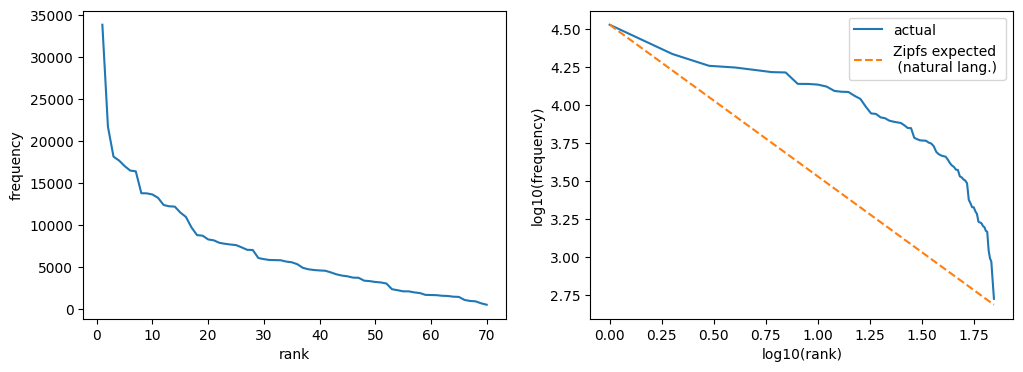

In [9]:
ziff = True
if ziff:
    # on hold: f_frq = documents.sort_values("frequency_in_document", ascending=False)["frequency_in_document"].reset_index(drop=True)
    df_frq = documents.groupby("element").sum().iloc[:,1].sort_values(ascending=False)
    df_frq.index = range(1,len(df_frq)+1)
    ranks = df_frq.index
    freqs = df_frq.values

    # theoretical zipf
    zslope, zinter = np.polyfit(x=ranks, y=freqs, deg=1)
    zC = freqs[0]
    tfreqs = [zC*(i**-1) for i in ranks]
    tfreqs

    
    # plotting the figures
    fig, [ax1,ax2] = plt.subplots(1,2, figsize=(12,4))

    ax1.plot(df_frq)
    ax1.set_xlabel("rank")
    ax1.set_ylabel("frequency")

    
    ax2.plot(np.log10(ranks),
             np.log10(freqs),
             label="actual")
    
    ax2.plot(np.log10(ranks),
             np.log10(tfreqs),
             label="Zipfs expected \n (natural lang.)",
             ls="--"
            )
    ax2.legend(loc=1)

    ax2.set_xlabel("log10(rank)")
    ax2.set_ylabel("log10(frequency)")

    if save_figs == True:
        time = datetime.now().strftime("[%d.%m.%y-%H;%M]")
        fig.savefig('output\\{} new_covid_vaccine_zipfs.png'.format(time), bbox_inches='tight')

---
* Creating PCA object for futher use
* Applying PCA to the raw KLDe distances matrix
> need to fix the scaling

In [10]:
matrix_t = matrix_input.T[matrix_input.T.columns]
cond_75p = (matrix_t .std(axis=0) >= 0.9)#matrix_t .std(axis=0).describe()["75%"])
X = matrix_t.T[cond_75p].T

In [11]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans

pipeline = Pipeline([("scaling", StandardScaler()),
                     ("pca", PCA(n_components=0.95, random_state=42)),
                     ("kmeans", KMeans(n_clusters=4, random_state=42))])

X = matrix_input.T[matrix_input.T.columns]
X_pca = pipeline["pca"].set_output(transform="pandas").fit_transform(X)
pipeline.fit(X)

Pipeline(steps=[('scaling', StandardScaler()),
                ('pca', PCA(n_components=0.95, random_state=42)),
                ('kmeans', KMeans(n_clusters=4, random_state=42))])

In [12]:
X_pca_vratio = pipeline["pca"].explained_variance_ratio_
X_pca_vratio

array([0.31250355, 0.15113524, 0.11168013, 0.0956659 , 0.07443696,
       0.0575282 , 0.04859284, 0.04519863, 0.03097186, 0.02768119])

Text(0, 0.5, 'Inertia')

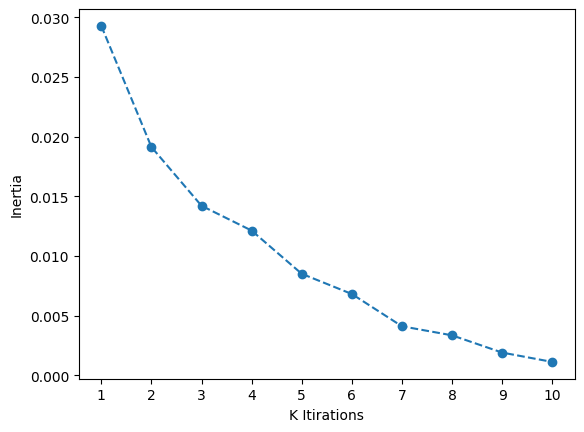

In [13]:
# Elbow Plow
inertia_list = np.array([KMeans(n_clusters=i, random_state=42).fit(X_pca).inertia_ for i in np.arange(1,11,1)])

x_array = np.arange(1, len(inertia_list)+1)
y_array = inertia_list
plt.scatter(x=x_array, y=y_array )
plt.plot(x_array, y_array, ls="--")
plt.xticks(x_array)
plt.xlabel("K Itirations")
plt.ylabel("Inertia")

In [14]:
# Creating Model
km_result = pd.DataFrame({"actual": X.index.str.split(".").to_series().apply(lambda x : x[1]).values,
                          "pred":pipeline.fit_predict(X)})
km_result
km_result.to_csv("kmeans.csv")

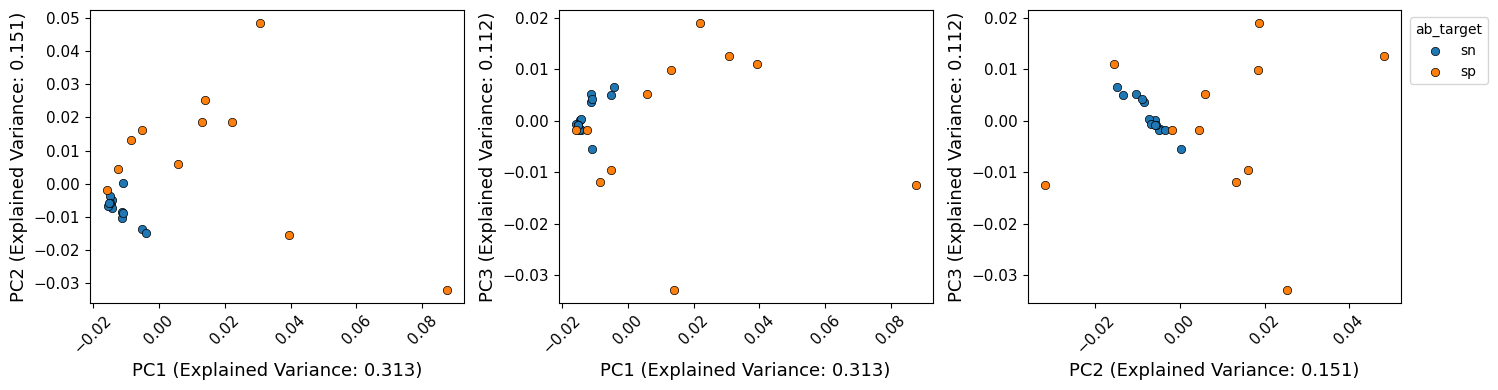

In [16]:
var_list = [round(i,3) for i in X_pca_vratio[:3]]

pca1_df = X_pca
pca1_df.columns = [f"PC{i}" for i in range(1,pca1_df.shape[1]+1)]

# unique ab_target types

index_i = 0
values = pca1_df.index.str.split(".").to_series().apply(lambda x : x[index_i]).unique()

fig, axs = plt.subplots(1,3, figsize=(15,4))

for ab in values:
    cond_slice = (pca1_df.index.str.split(".").to_series().apply(lambda x : x[index_i]) == ab).values
    dataset_slice = pca1_df[cond_slice]

    PCs = ["PC"+str(i) for i in range(1,4)]
    for i,j in zip([0,1,2],[[1,2],[1,3],[2,3]]):
        PCi = f"PC{j[0]}"
        PCj = f"PC{j[1]}"

        axs[i].scatter(dataset_slice[PCi], 
                       dataset_slice[PCj], 
                       label=ab,
                       edgecolor="black",
                       lw=0.5)

        axs[i].tick_params(axis="both", labelsize=11)
        axs[i].tick_params(axis="x", rotation=45)
        axs[i].set_xlabel(PCi + f" (Explained Variance: {str(var_list[j[0]-1])})", fontsize=13)
        axs[i].set_ylabel(PCj + f" (Explained Variance: {str(var_list[j[1]-1])})", fontsize=13)
    
plt.legend(title="ab_target",loc="upper right", bbox_to_anchor=(1.25, 1) )

plt.tight_layout()
plt.show()

In [17]:
X_pca

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9
sn.1.subj_3,-0.011263,-0.010457,0.005267,0.001673,-0.001004,0.003551,0.004077,0.005096,-0.000433
sn.1.subj_4,-0.014504,-0.004782,-0.001626,-0.002054,-0.001595,-0.004448,-0.002915,0.000022,0.000048
sn.1.subj_5,-0.014532,-0.005914,0.000204,-0.002618,-0.001990,-0.005076,-0.004410,-0.000404,0.000719
sn.1.subj_6,-0.011097,-0.008551,0.003700,0.003321,-0.001292,0.005104,0.003069,0.005752,-0.001441
sn.2.subj_3,-0.005039,-0.013584,0.005014,0.002390,-0.001653,0.005513,0.005052,0.002296,-0.002193
sn.2.subj_4,-0.014179,-0.004871,-0.001713,-0.002145,-0.001602,-0.004342,-0.003382,-0.000137,0.000355
sn.2.subj_5,-0.014119,-0.007439,0.000430,-0.002748,-0.002380,-0.005604,-0.004424,0.000877,0.000731
sn.2.subj_6,-0.014930,-0.003594,-0.001712,-0.002065,-0.001925,-0.003700,-0.003506,-0.000939,-0.000008
sn.2.subj_7,-0.010808,-0.008879,0.004180,0.003206,-0.001542,0.003410,0.004870,0.005255,-0.001261
sn.4.subj_3,-0.015569,-0.006798,-0.000596,-0.002736,-0.002000,-0.003640,-0.004301,-0.000072,0.001637


In [18]:
index_df = pd.DataFrame(data=list(X_pca.index.str.split(".")), columns=[ "ab_target", "time_point", "subject_id"])
#bool_mask = np.array(index_df.dataset == "a")
#Xn_pca = X_pca[bool_mask]

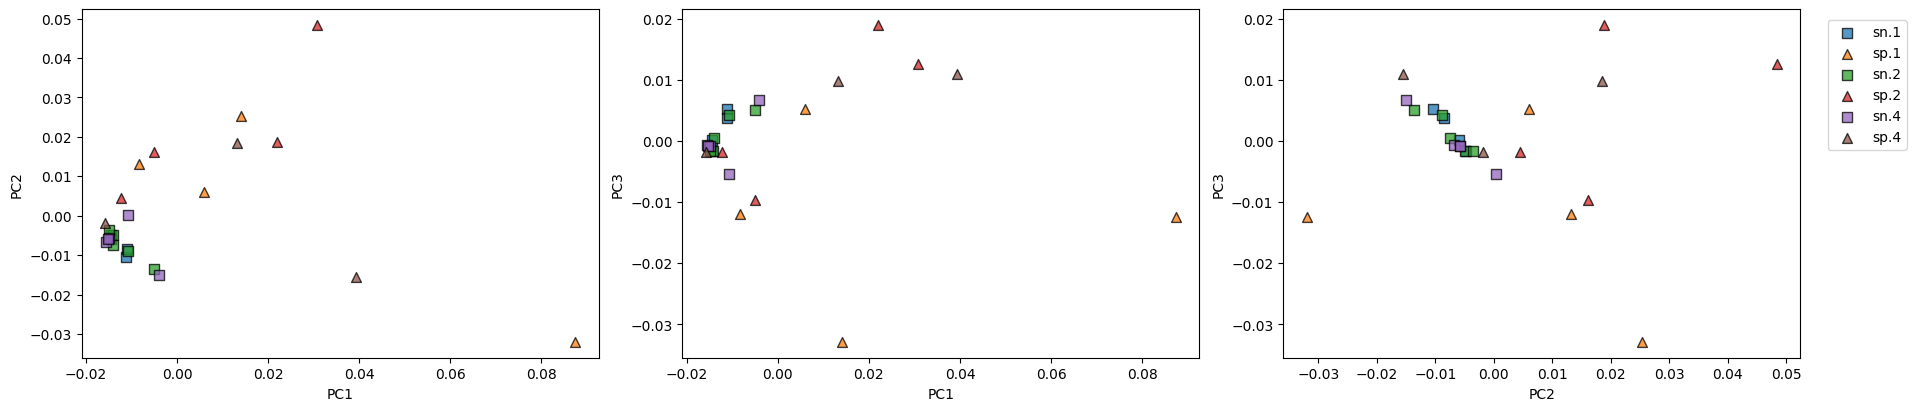

In [19]:
pca1_df.columns = [f"PC{i}" for i in range(1,pca1_df.shape[1]+1)]

# unique ab_target types

index_ab = 0 
values_ab = pca1_df.index.str.split(".").to_series().apply(lambda x : x[index_ab]).unique()
ab_marker = {key:value for key,value in zip(values_ab,["s","^"])}

index_tp = 1 
values_tp = pca1_df.index.str.split(".").to_series().apply(lambda x : x[index_tp]).unique()

fig, axs = plt.subplots(1,3, figsize=(18,4), constrained_layout=True)

for tp in values_tp:
    for ab in values_ab:
        cond_slice_ab = (pca1_df.index.str.split(".").to_series().apply(lambda x : x[index_ab]) == ab).values
        cond_slice_tp = (pca1_df.index.str.split(".").to_series().apply(lambda x : x[index_tp]) == tp).values

        dataset_slice = pca1_df[cond_slice_ab & cond_slice_tp]
        PCs = ["PC"+str(i) for i in range(1,4)]
        for i,j in zip([0,1,2],[[1,2],[1,3],[2,3]]):
            PCi = f"PC{j[0]}"
            PCj = f"PC{j[1]}"
            axs[i].scatter(dataset_slice[PCi], 
                           dataset_slice[PCj], 
                           label=".".join([ab,tp]),
                           marker = ab_marker[ab],
                           s=50, alpha=0.75, edgecolors="black", linewidths=1)
            axs[i].set_xlabel(PCi)
            axs[i].set_ylabel(PCj)

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles=handles, labels=labels, loc=7, bbox_to_anchor=(0.56, 0.55, 0.5, 0.5))
plt.show()

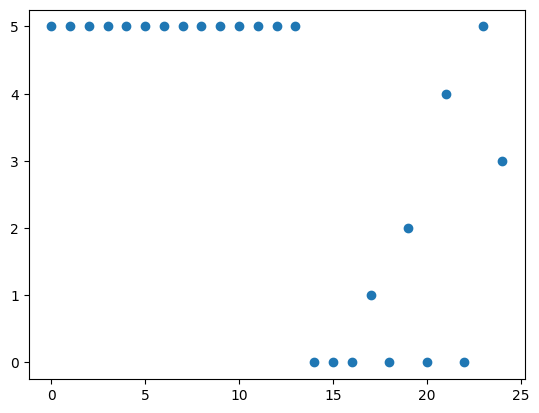

In [20]:
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
X = matrix_input.T
X_6km = pd.DataFrame(KMeans(n_clusters=6, random_state=0).fit_predict(X))

plt.scatter(x=X_6km.index, y=X_6km[0])

---
* Plotting the PCA_1 results as scatter plot
* Plotting 3d dotplot of PC1,PC2 and PC3
* Plotting the explained variance of each PC component as bar chart
> need to add shape to "sp" and "sn" datasets

Color marks unique:  ['1' '2' '4']
Shape marks unique:  ['sn' 'sp']


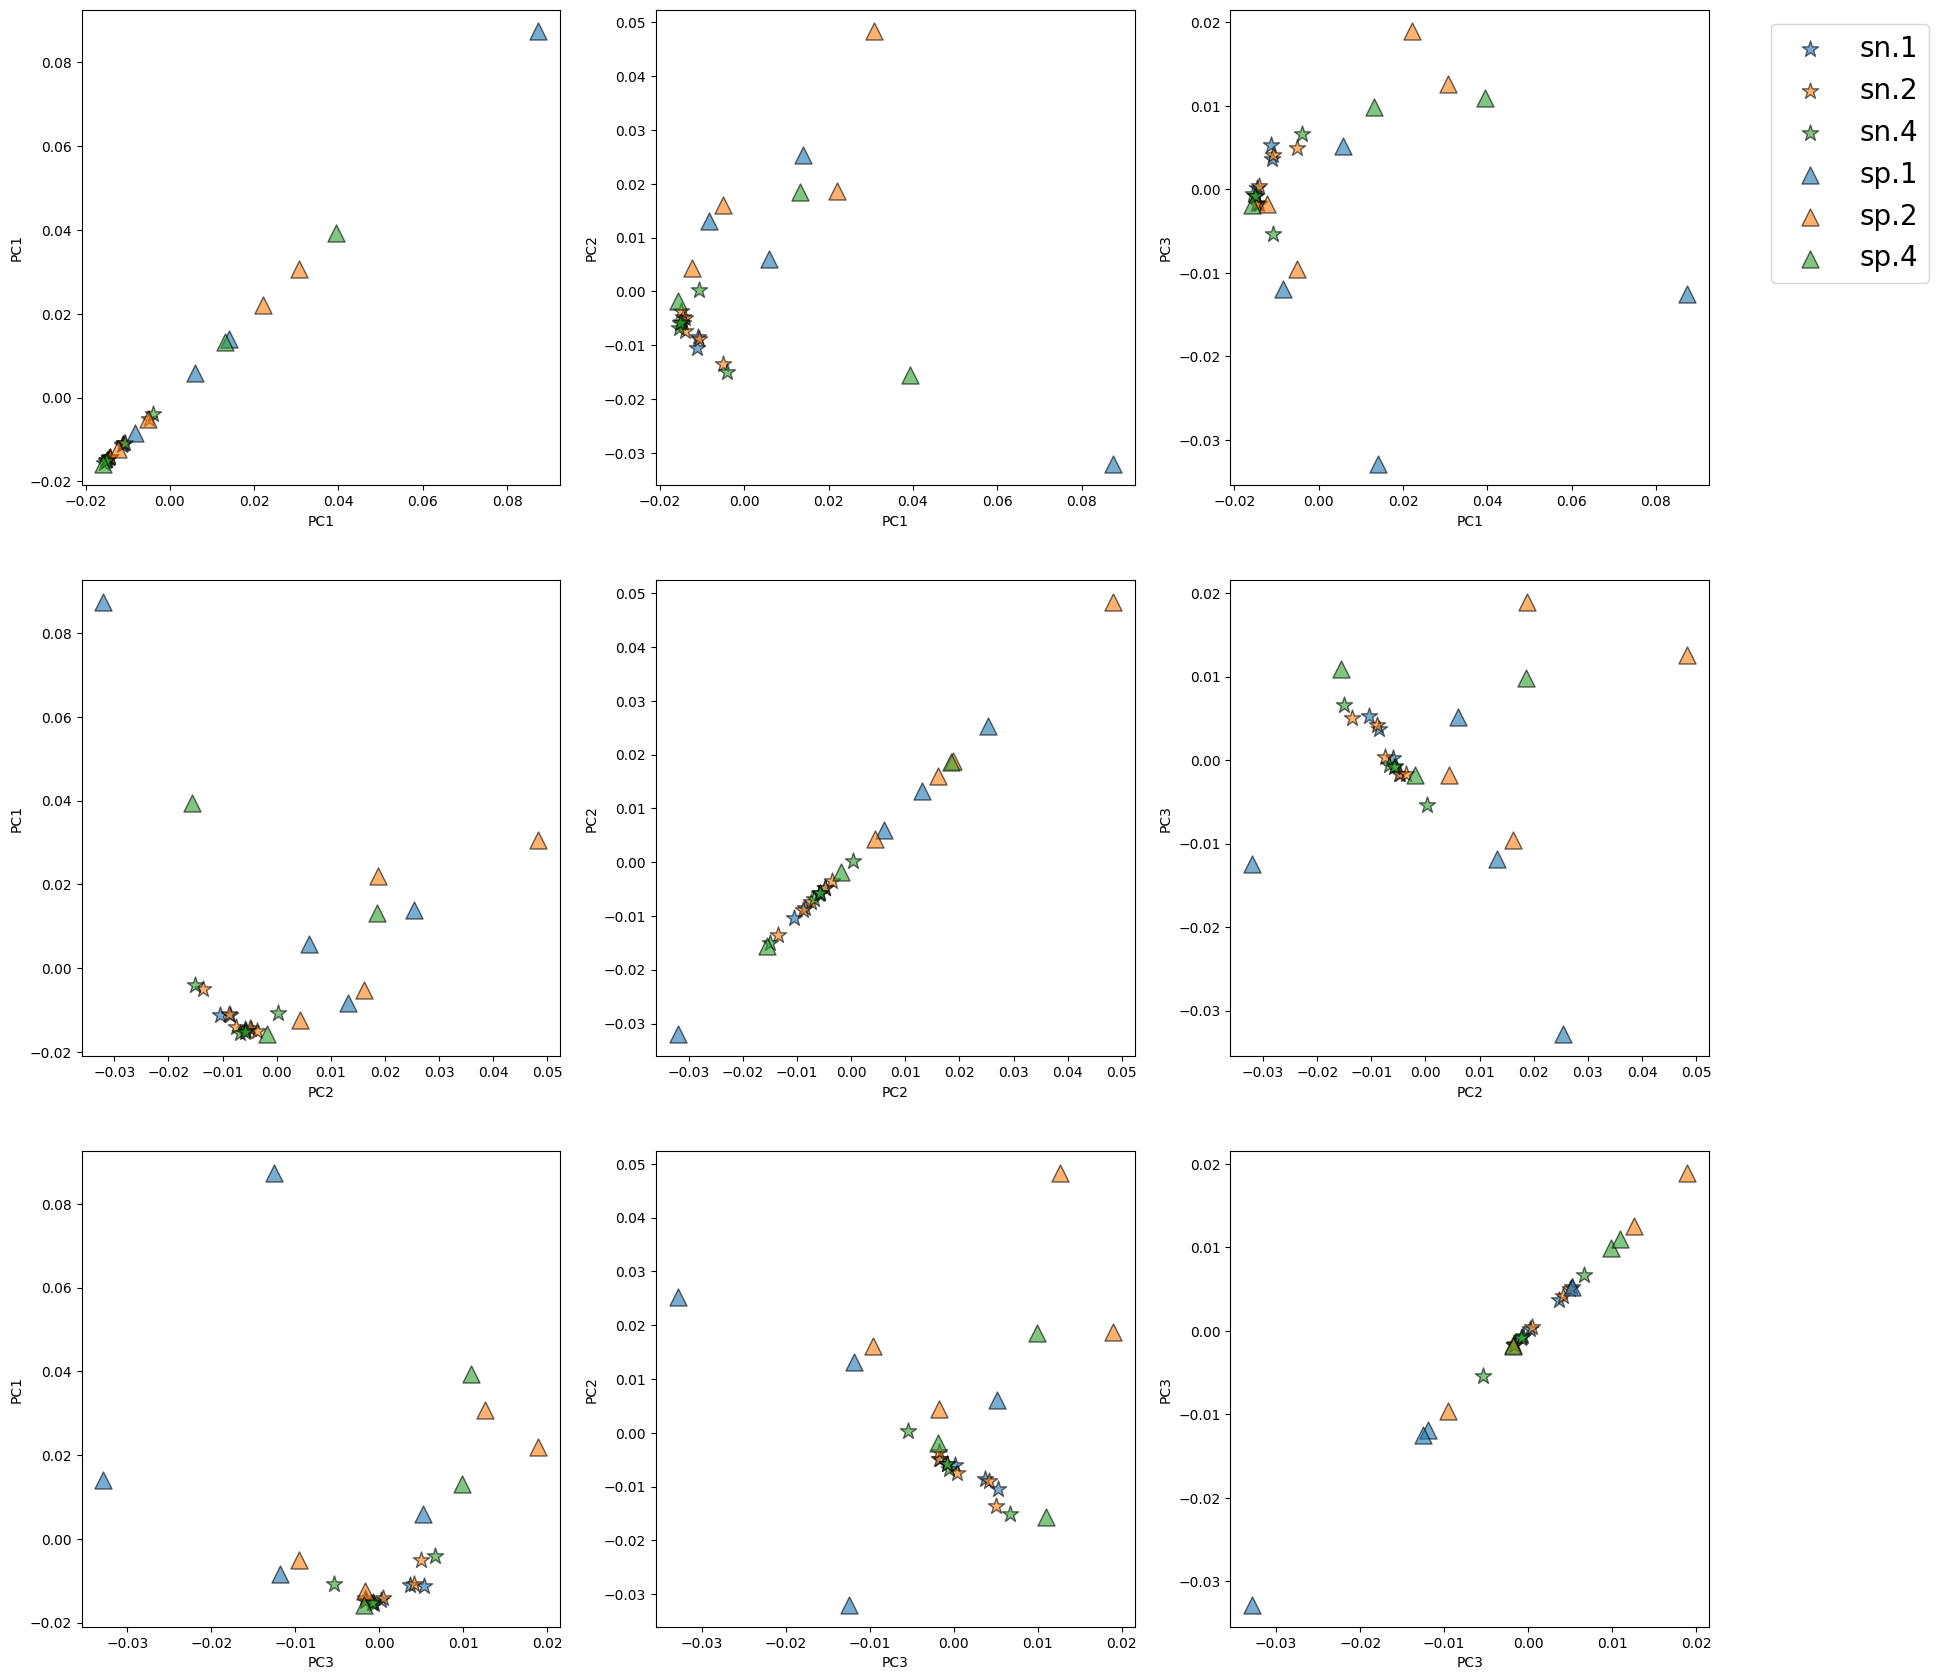

In [21]:
pca_scatter(pca1_df, color_index=1)

---
* Creating normilzed heatmap of distances between the different documents in the domain: </br>
  (1) LPA visutalize plot </br>
  (2) My version of the same plot but orginzed diffrently visually
* Applying PCA of the scaled (standard-scaler) dsitances between documents to each others </br>
  (1) PCA scallerplot  visutalize plot </br>
  (2) My version of the same plot but orginzed diffrently visually

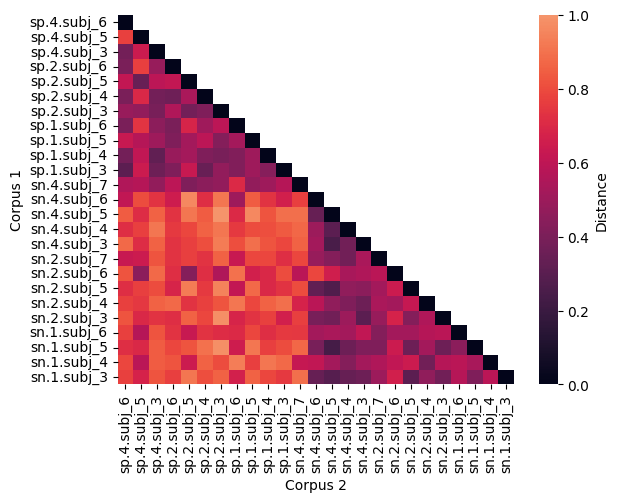

In [22]:
spd_mx = sockpuppet_distance(corpus, corpus, res="matrix")

mask = np.triu(np.ones_like(spd_mx),k=1).T
ax = sns.heatmap(data=spd_mx, 
                 center=spd_mx.median().mean(),
                 xticklabels=True, 
                 yticklabels=True,
                 cbar_kws={'label': 'Distance'},
                 cmap="rocket",
                 mask = mask)
ax.invert_yaxis()
ax.invert_xaxis()
#ax.yaxis.tick_right()
plt.yticks(rotation=0)

if save_figs == True:
    time = datetime.now().strftime("[%d.%m.%y-%H;%M]")
    plt.savefig('output\\{} new_covid_vaccine_spd_heatmap.png'.format(time), bbox_inches='tight')

plt.show()

In [23]:
pca2_df, pca2_var = do_pca(spd_mx)
print("'pca2' Explained Variance: \n", pca2_var)

'pca2' Explained Variance: 
     PC  Variance
0  PC1  0.682811
1  PC2  0.149557
2  PC3  0.031559
3  PC4  0.023919
4  PC5  0.018055
5  PC6  0.017703
6  PC7  0.013270
7  PC8  0.012038
8  PC9  0.010021


Color marks unique:  ['1' '2' '4']
Shape marks unique:  ['sn' 'sp']


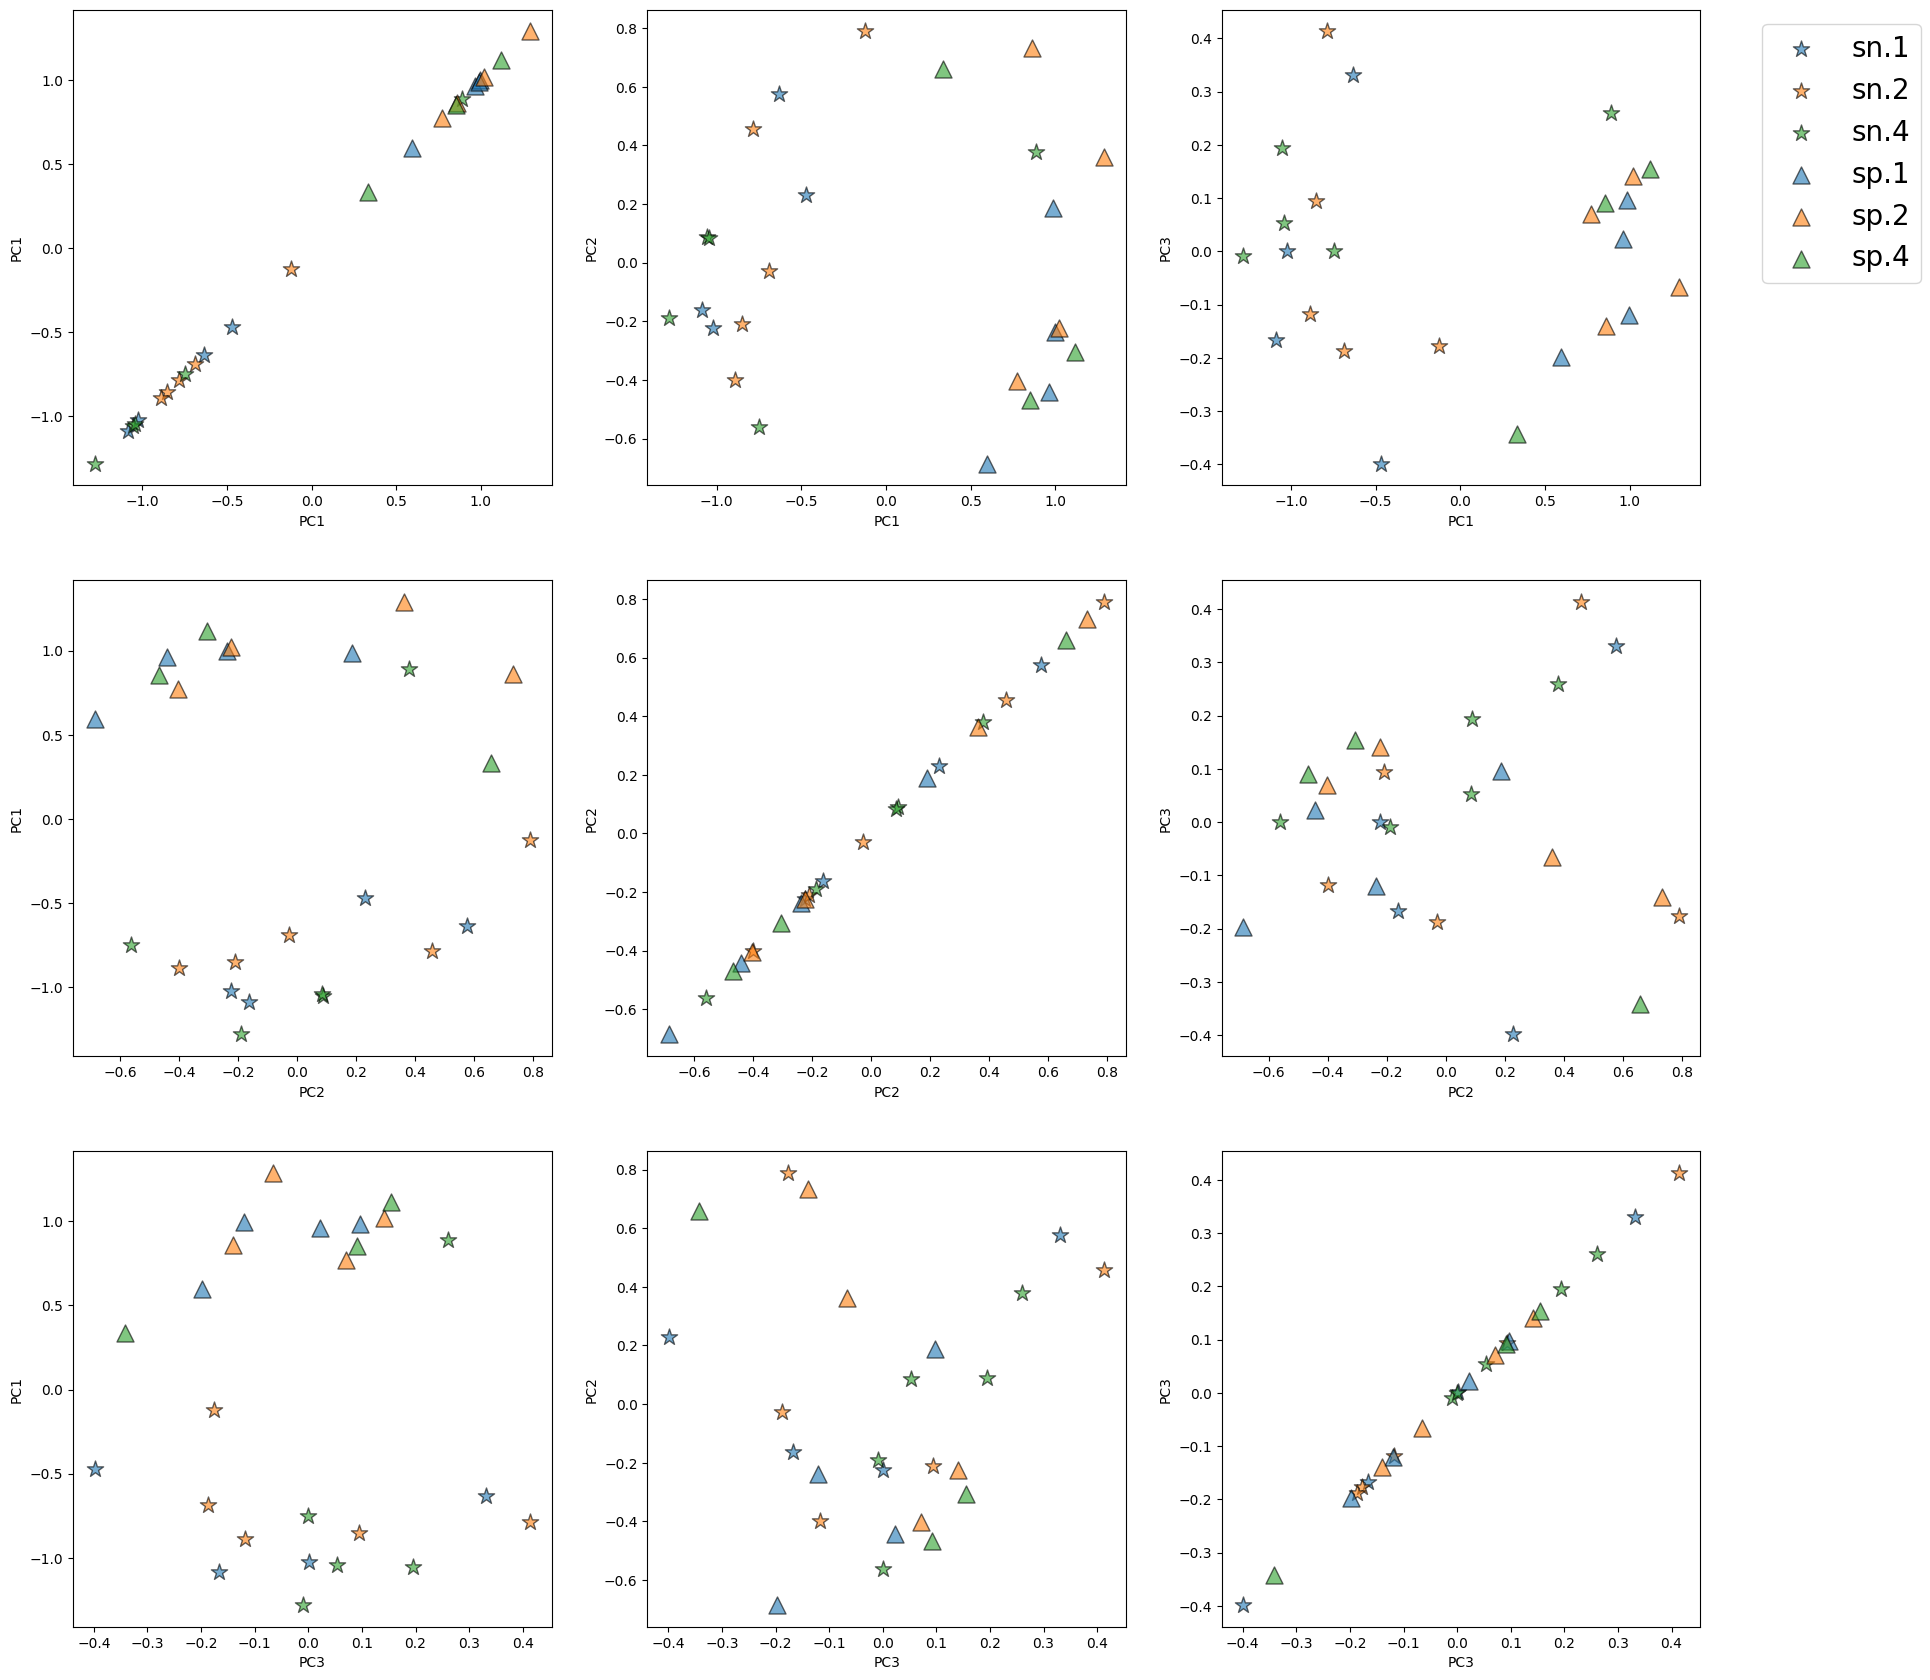

In [24]:
pca_scatter(pca2_df, color_index=1)

---
* Creating median distance (all the subjects combined) value across the amino acids position (each subject assigned dot marked in different colors)

In [25]:
dist_matrix = sig_df[[i for i in sig_df.columns if i.split(".")[1]=="sp"]].T
dist_means = dist_matrix.mean()
dist_std = dist_matrix.std()

In [26]:
dist_bar = pd.DataFrame({"mean":dist_means,"std":dist_std})
dist_bar_sorted = dist_bar.sort_values("mean", ascending=False)
dist_bar_sorted["pos"] = dist_bar_sorted.index.astype("str")
dist_bar_sorted.reset_index(drop=True, inplace=True)

dist_bar_sorted = dist_bar_sorted.iloc[3:,:]

---
* Dividing the subjects median values and presenting them across the amino acid positions as dots

In [27]:
def place_nan(signatures_df : pd.DataFrame,
              mask_df : pd.DataFrame) -> pd.DataFrame:
    """
    custom function that place np.nan in a distrebution 
    matrix according to masking matrix True values.
    """

    if all(signatures_df.columns == mask_df.columns) & all(signatures_df.index == mask_df.index):
        values_df = signatures_df
        for col in signatures_df.columns:
            values_df.loc[mask_df[col], col] = np.nan

        return values_df
    
    else:
        raise ValueError('Missmatch between mask matrix and signiture matrix')
    
# getting filter column for futher processing
get_filter_col = lambda x : ".".join([x.split(".")[0],x.split(".")[-1]])

# dist_df with np.nan values where the mutations count is 0.   
dist_values = place_nan(sig_df,mask_zeros)
dist_values = dist_values.T
dist_values["filter"] = dist_values.index
dist_values["filter"] = dist_values["filter"].apply(get_filter_col)

In [28]:
columns = np.unique([".".join([i[0],i[2]]) for i in [j.split(".") for j in dist_values.T.columns]])
indexes = dist_values.T.index
median_df = pd.DataFrame(data=np.nan, index=indexes[:-1], columns=columns)

for dataset in median_df.columns:
    cond_dataset = dist_values["filter"] == dataset
    median_df[dataset] = dist_values[cond_dataset].iloc[:,:-1].median(skipna=False)

halfing = int(median_df.shape[1]/2)
median_sn = median_df.iloc[:,:halfing]
median_sp = median_df.iloc[:,halfing:]

In [29]:
def subject_medians(input_df : pd.DataFrame) -> pd.DataFrame:

    func_df = input_df.copy()
    null_report = func_df.isnull().sum(axis=1)
    func_df["null_sum"] = null_report
    func_df[func_df["null_sum"] > 2] = np.nan

    return func_df.iloc[:,:-1], null_report

medians_sp, report_sp = subject_medians(median_sp)
medians_sn, report_sn = subject_medians(median_sn)

In [30]:
if True:
    sp_index = medians_sp.median(axis=1).sort_values().index
    medians_sp = medians_sp.loc[sp_index,:]
    medians_sn = medians_sn.loc[sp_index,:]

In [31]:
def attach_dropped(indf : pd.DataFrame, 
                   missing_df : pd.DataFrame) -> pd.DataFrame:
    
    missing_rows = np.setdiff1d(missing_df.element.unique(), indf.index.values)
    mssing_df = pd.DataFrame(data=np.nan, index = missing_rows , columns = indf.columns)

    return pd.concat([indf, mssing_df], axis=0)

medians_sp = attach_dropped(medians_sp, docuemnts_zero)
medians_sn = attach_dropped(medians_sn, docuemnts_zero)

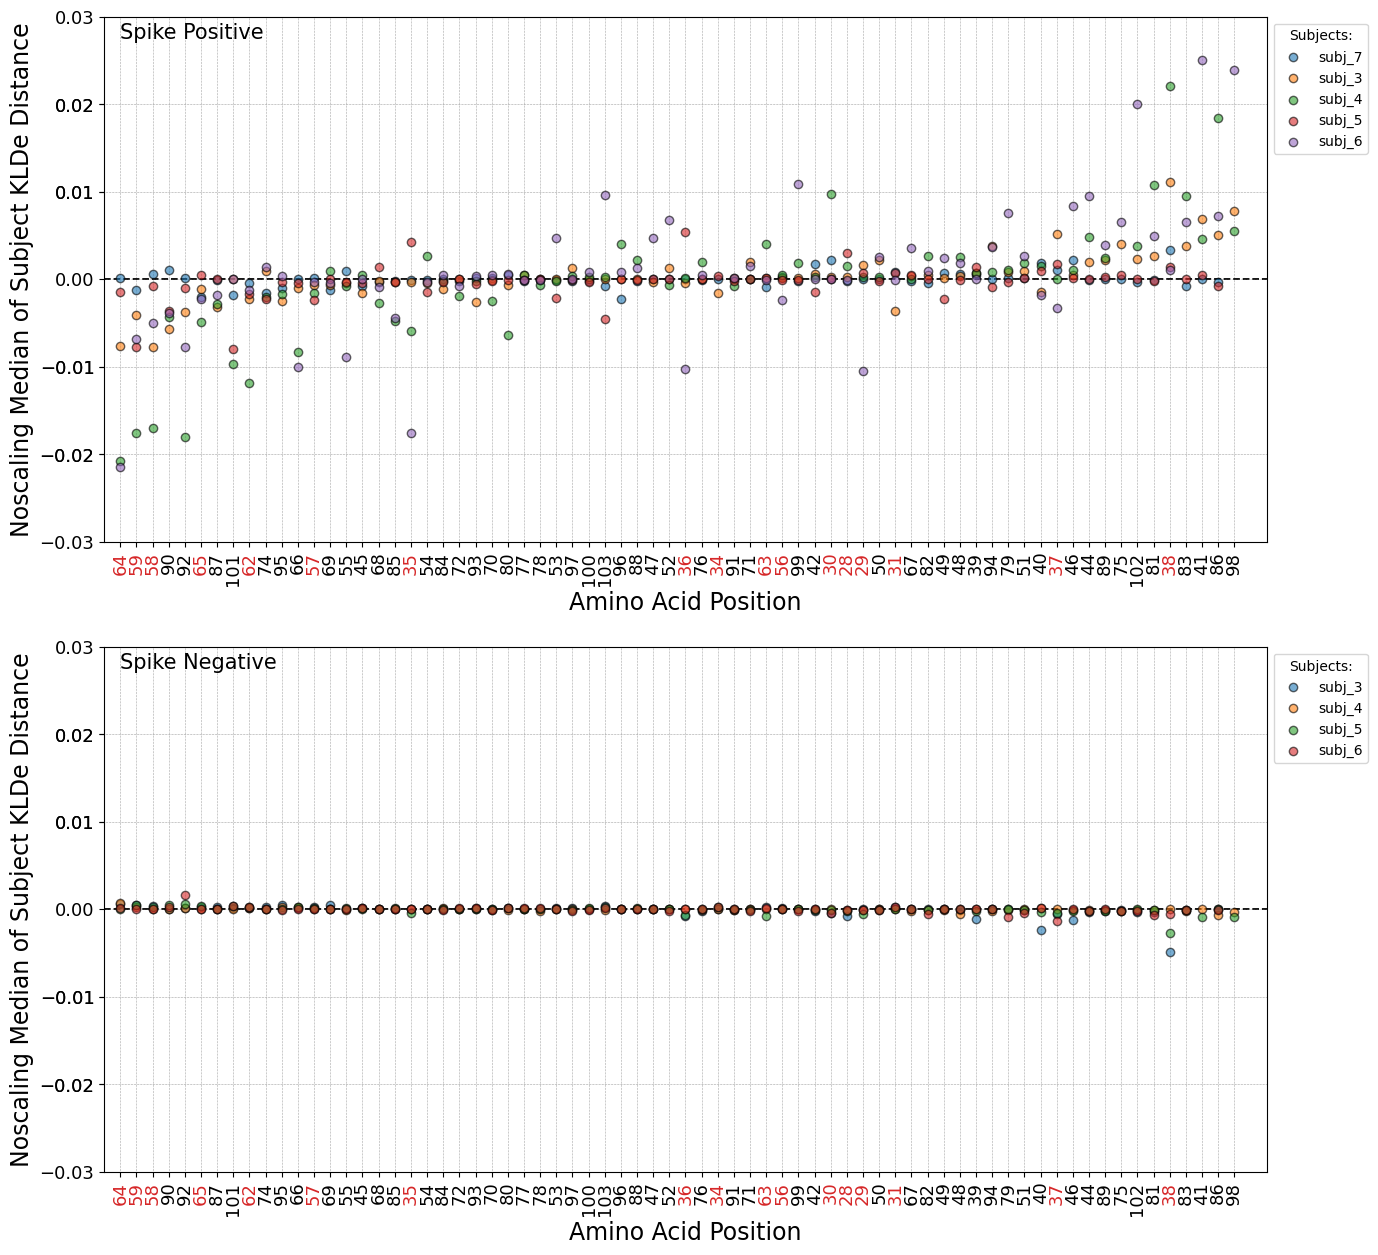

In [32]:
method = "median"
scaler = "nocaling"

get_scatter(medians_sp.dropna(how="all"), 
            medians_sn.dropna(how="all"), 
            method=method,
            same_yticks=True, 
            to_scale="noscaling", 
            types=["Spike Positive", "Spike Negative"],
            save_figure=False)

---
* importing dataframe of mutation number per position in each dataset

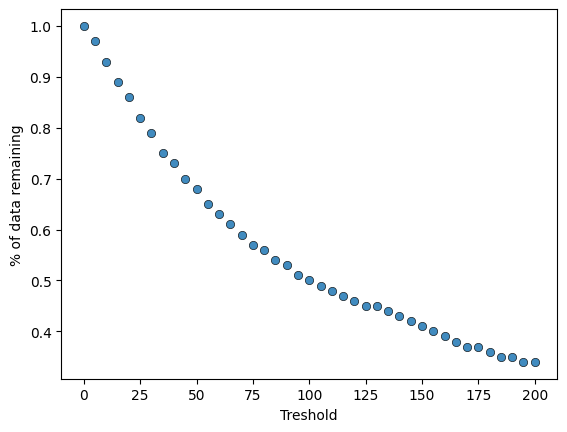

In [34]:
sizes = pd.read_csv(f"{input_name}\\covid_vaccine_new.dataset_sizes.csv", index_col = 0)
pres_treshold = lambda df, tresh : f"{round(df[df["n_mut"] >= tresh].shape[0]/df.shape[0],2):0.2f}% ({df[df["n_mut"] >= tresh].shape[0]}/{df.shape[0]})"
pres_treshold(sizes,20)

x_axis = np.arange(0,205,5)
y_axis = [float(pres_treshold(sizes,i)[:4]) for i in x_axis]

plt.scatter(x=x_axis,
            y=y_axis,
            color="tab:blue",
            edgecolors="black",
            linewidths=0.5,
            alpha=0.85)
plt.xlabel("Treshold")
plt.ylabel("% of data remaining")
plt.show()

----

* Looking for the top position, which will be used in later analysis

In [35]:
ticks_array = np.array([-4,-2,-1,0,1,2,3])
tick_uniques = np.unique(np.abs(ticks_array))
ticks_final = np.unique(np.concatenate((tick_uniques,-tick_uniques)))

In [36]:
medians_vals = medians_sp.dropna(how="all").T.median()
na_num = medians_sp.dropna(how="all").isna().apply(sum, axis=1)

if all(medians_vals.index == na_num.index):
    medians_summery = pd.DataFrame({"pos_aa":medians_vals.index,
                                    "median":medians_vals,
                                    "na_count":na_num}).sort_values(by="median",ascending=False).reset_index(drop=True)
    
head_10 = medians_summery.head(10).pos_aa.values
tail_10 = medians_summery.tail(10).pos_aa.values

In [37]:
medians_desc = medians_summery.describe()
head_10 = medians_summery[medians_summery["median"] >= medians_desc.loc["75%","median"]].sort_values(by="median", ascending=False)
tail_10 = medians_summery[medians_summery["median"] <= medians_desc.loc["25%","median"]].sort_values(by="median", ascending=True)

In [38]:
tail_10.pos_aa.astype("int").values

array([ 64,  59,  58,  90,  92,  65,  87, 101,  62,  74,  95,  66,  57,
        69,  55,  45,  68,  85])

In [39]:
print(head_10.pos_aa.astype("int").values, tail_10.pos_aa.astype("int").values)

[ 98  86  41  83  38  81 102  75  89  44  46  37  40  51  79  94  39  48] [ 64  59  58  90  92  65  87 101  62  74  95  66  57  69  55  45  68  85]
